In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In this Jupyter Notebook we'll be loading all the datasets created out of the scraping jobs, in order to do some extra cleaning and then save them again to be used in the modelling stage. The details of what we'll be doing on each dataset will be explained in each one of the following chapters with comments.

## Loading the datasets created during scraping

### Clubs and players

In [26]:
players_df = pd.read_csv('Final_datasets/final_list_of_sampled_players.csv') # CLEAN

In [9]:
teams_df = pd.read_csv('Final_datasets/final_list_of_teams.csv') # CLEAN

### Players statistics

In [10]:
def_stats_df = pd.read_csv('Final_datasets/Defensive_stats') # CLEAN

In [11]:
of_stats_df = pd.read_csv('Final_datasets/Offensive_stats') # CLEAN

In [365]:
summary_stats_df = pd.read_csv('Final_datasets/Summary_stats') # CLEAN

### Rankings

In [1181]:
clubs_ranking_df = pd.read_csv('Final_datasets/final_clubs_teams_ranking.csv') # CLEAN

In [15]:
nat_teams_ranking_df = pd.read_csv('Final_datasets/final_nat_teams_ranking.csv') # CLEAN

### Brand value data

In [3]:
tw_sentiment_df = pd.read_csv('Final_datasets/final_tweets.csv') # CLEAN

In [31]:
google_results_df = pd.read_csv('Final_datasets/google_results_def_v2.csv') # CLEAN

### Other data

In [4]:
basic_info_df = pd.read_csv('Final_datasets/Basic_info') # CLEAN

In [865]:
ages_df = pd.read_csv('Final_datasets/final_ages.csv') # CLEAN

In [1381]:
injuries_df = pd.read_csv('Final_datasets/final_injuries.csv')

In [21]:
national_apps_df = pd.read_csv('Final_datasets/final_national_apps.csv') # CLEAN

In [1545]:
awards_df = pd.read_csv('Final_datasets/final_players_awards.csv') # CLEAN

In [1556]:
awards_categories_df = pd.read_csv('Final_datasets/awards_category.csv') # CLEAN

In [3]:
several_and_target_df = pd.read_csv('Final_datasets/final_several_features_VALUEEE.csv') # CLEAN

## Merging players, teams and rankings

#### Adding rankings to teams

In [999]:
# Adjusting columns to match with teams_df

clubs_ranking_df.columns = ['ranking','team','country']

In [995]:
# Removing accents to posterior joining between teams and rankings

import unicodedata
from six import u as unicode

def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', unicode(input_str))
    return u"".join([c for c in nkfd_form if not unicodedata.combining(c)])

teams_df['clean_team'] = [remove_accents(x).lower() for x in teams_df.team]
clubs_ranking_df['clean_team'] = [remove_accents(x).lower() for x in clubs_ranking_df.team]

In [1018]:
# As in between datasets (ranking, teams scraped from Whoscored, teams scraped from Transfermarkt) the teams
# names where not matching, it resulted necesary to create some functions to match names.
# For example, you could 'F.C. Barcelona' in one dataset and just 'Barceona' in another.
# Also, there were words repeated in between leagues and countries (for example: 'United', 'San' or 'Club')
# That's why the first thing was to find a list of all the repetead words per league.
# Once I had the list of repeated words per league I just dropped the teams in each league with any of those words.

def repetead_words(teams_ranking, teams_list):
    
    repeated = {'word': [], 'country': []}
    countries = list(teams_ranking.country.unique())
    returner = {}
        
    for each_country in teams_list.country.unique():
        for each in teams_list.clean_team[teams_list.country==each_country]:
            list_team_words = each.split()
            repeated['word'] += list_team_words
            repeated['country'] += [each_country for i in range(len(list_team_words))]
    
    for each_country_2 in teams_ranking.country.unique():
        for each_2 in teams_ranking.clean_team[teams_ranking.country==each_country_2]:
            ranking_team_words = each_2.split()
            repeated['word'] += ranking_team_words
            repeated['country'] += [each_country_2 for i in range(len(ranking_team_words))]    
    
    rep = pd.DataFrame(repeated)
    
    for each in countries:
        returner[each] = list(rep.word[rep.country == each].value_counts()[rep.word[rep.country == each].value_counts() > 2].keys())
    
    return returner

In [1019]:
# Running function to find repetead words
repetead_words = repetead_words(clubs_ranking_df, teams_df)

In [1025]:
# Correcting by hand some teams that I wanted to conserve

clubs_ranking_df.clean_teams = clubs_ranking_df.clean_team.map(lambda v: 'mancity' if v == 'manchester city' else v)
clubs_ranking_df.clean_teams = clubs_ranking_df.clean_team.map(lambda v: 'manun' if v == 'manchester united' else v)
teams_df.clean_teams = teams_df.clean_team.map(lambda v: 'mancity' if v == 'manchester city' else v)
teams_df.clean_teams = teams_df.clean_team.map(lambda v: 'manun' if v == 'manchester united' else v)

In [1088]:
# The next function takes the list of repetead words and all teams, to add their ranking

def add_ranking(ranking_df, teams_df, rep):
    
    returner = {'team':[], 'ranking':[], 'league': []}
    
    for each_country in teams_df.country.unique():
        for each_team in teams_df.clean_team[teams_df.country==each_country]:
            returner['league'].append(teams_df.league[teams_df.clean_team==each_team].item())
            returner['team'].append(each_team)
            team_words = each_team.split()
            remove_words = rep[each_country]
            def_team_words = [x for x in team_words if x not in remove_words]
            
            append = False
            for team_ranking in ranking_df.clean_team[ranking_df.country == each_country]:
                count = 0
                ranking_team_words = team_ranking.split()
                def_ranking_team_words = [x for x in ranking_team_words if x not in remove_words]
                for each_word in def_ranking_team_words:
                    if each_word in def_team_words:
                        if not append:
                            ranking_value = ranking_df.ranking[(ranking_df.clean_team == team_ranking) & (ranking_df.country == each_country)].item()
                            returner['ranking'].append(ranking_value)
                            append = True
                            
            if not append:
                returner['ranking'].append(np.nan)     
                        
    return returner

In [1110]:
ranking_search = add_ranking(clubs_ranking_df, teams_df, repetead_words)

In [1111]:
ranking_search_df = pd.DataFrame(ranking_search)

In [1112]:
# Eventhough the previous function save us a lot of time, we were missing some teams aniway.
# So we had to do some manual check.

for league in ranking_search_df.league[pd.isnull(ranking_search_df.ranking)].value_counts().index:
    null_v = ranking_search_df.ranking[ranking_search_df.league==league].notnull().sum()
    print(league + " has: " + str(null_v))

Championship (ENG) has: 1
MLS (USA) has: 2
Bundesliga 2 (GER) has: 0
Eredivise (NET) has: 2
La Liga 2 (SPA) has: 0
Super Lig (TUR) has: 2
Ligue 1 (FRA) has: 4
Liga NOS (POR) has: 4
Super League (CHI) has: 4
Serie A (ITA) has: 11
Premier Liga (RUS) has: 7
Premier League (ENG) has: 12
Bundesliga (GER) has: 8
La Liga (SPA) has: 15
Primera División (ARG) has: 18


Checking one by one. Ranking has only teams ranked 200 or above:

* Championship OK
* MLS OK
* Bundesliga 2 OK
* Eredivise OK
* La liga 2 OK
* Ligue 1: lyon (56), paris saint-germain (28)
* Liga NOS OK
* Super League OK
* Seria A: inter(32)
* Premier Liga OK
* Premier League: manun (33), mancity (4)
* Bundesliga OK
* La Liga: real madrid (2)
* Primera División OK

In [1134]:
# Checking teams in every league missing values. In the example we were checking teams for the 'Premier Liga'

ranking_search_df[(ranking_search_df.league.str.contains('Premier Liga')) & (pd.isnull(ranking_search_df.ranking))]

,team,ranking,league
165,fc orenburg,NaN,Premier Liga (RUS)
168,rubin kazan,NaN,Premier Liga (RUS)
169,fc yenisey krasnoyarsk,NaN,Premier Liga (RUS)
170,anzhi makhachkala,NaN,Premier Liga (RUS)
171,ural,NaN,Premier Liga (RUS)
172,fk akhmat,NaN,Premier Liga (RUS)
175,krylya sovetov samara,NaN,Premier Liga (RUS)
176,fc ufa,NaN,Premier Liga (RUS)
178,dinamo moscow,NaN,Premier Liga (RUS)


In [1147]:
# Assigning correct values to the identified missing teams (just 6)

correct_teams = {'team':['lyon','paris saint-germain','inter','manun','mancity','real madrid'],
                'ranking': [56,28,32,33,4,2]}

for ranking, team in zip(correct_teams['ranking'], correct_teams['team']):
    ranking_search_df.ranking[ranking_search_df.team == team] = ranking

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [1149]:
ranking_search_df.columns = ['clean_team','ranking','league']

In [1152]:
teams_df = teams_df.merge(ranking_search_df, how='inner', on='clean_team')

In [1154]:
teams_df.drop(['clean_team','league_y'],axis=1,inplace=True)

#### Merging players and teams

In [1157]:
players_with_teams = players_df.merge(teams_df, how='inner', on='team')

In [1158]:
players_with_teams.shape

(1200, 10)

In [1159]:
players_with_teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 10 columns):
player      1200 non-null object
lastname    1200 non-null object
team        1200 non-null object
link_tm     1200 non-null object
link_ws     1200 non-null object
league_x    1200 non-null object
ws_link     1200 non-null object
tm_link     1200 non-null object
country     1200 non-null object
ranking     440 non-null float64
dtypes: float64(1), object(9)
memory usage: 103.1+ KB


In [1161]:
players_with_teams.columns = ['player', 'lastname', 'team', 'player_link_tm', 
                              'player_link_ws', 'league', 'team_ws_link','team_tm_link',
                              'team_country','team_ranking']

In [1172]:
# Doing some binning over the ranking

players_with_teams['team_clas'] = ['Top 10' if x < 11 else 'Top 50' if x < 51 else 'Top 100' if x < 101 else \
                                   'Top 150' if x < 150 else 'Top 200' if x < 150 else "Above 200" for x \
                                   in players_with_teams.team_ranking]

In [1173]:
players_with_teams = players_with_teams[['player', 'lastname', 'team', 'team_ranking', 'team_clas', 'league', 
                                         'team_country','player_link_tm','player_link_ws', 'team_ws_link','team_tm_link']]

In [1177]:
# Dropping the previous ranking column

players_with_teams.drop('team_ranking',axis=1,inplace=True)

In [1626]:
players_with_teams.to_csv(r'/Users/gonzaloferreiro/Documents/GA_Materials/DS_Inmersive/DSI8-lessons/projects/project-capstone/Moving_forward/Final_datasets/Cleaned_data/Players_and_teams.csv',index=False)

## Cleaning stats

In [38]:
# Checking shape of all stats tables

def_stats_df.shape

(6937, 10)

In [39]:
summary_stats_df.shape

(6040, 13)

In [40]:
of_stats_df.shape

(6944, 8)

### Deffensive stats

#### Initial loading and cleaning

In [152]:
def_stats_df.columns[:8]

Index(['interception', 'tackles', 'fouls', 'offsideswon', 'clearence',
       'wasdribbled', 'blocks', 'owngoals'],
      dtype='object')

In [153]:
for each in def_stats_df.columns[:8]:
    def_stats_df[each] = def_stats_df[each].map(lambda x: 0 if x == '-' else x)
    def_stats_df[each] = def_stats_df[each].astype(float)

#### Getting last and previous seasons independently

In [154]:
def_stats_last_season = def_stats_df.drop_duplicates(subset='link', keep='first')

In [155]:
index_rest = [x for x in def_stats_df.index.tolist() if x not in list(def_stats_last_season.index)]

In [156]:
def_stats_previous_seasons = def_stats_df.iloc[index_rest]

In [157]:
# Checking original length versus once divided

print(len(def_stats_previous_seasons) + len(def_stats_last_season))
print(len(def_stats_df))

6937
6937


In [158]:
def_stats_mean_previous_seasons = def_stats_previous_seasons.groupby(by='link').mean()

In [159]:
def_stats_mean_previous_seasons.reset_index(drop=False, inplace=True)

In [160]:
def_stats_last_season.reset_index(drop=True, inplace=True)

#### Getting everything together

In [161]:
def_stats_last_season.columns = ["last_"+x if x != "link" else x for x in def_stats_last_season.columns]

In [263]:
def_stats_mean_previous_seasons.columns = ["previous_"+x if x != "link" else x for x in \
                                           def_stats_mean_previous_seasons.columns]

In [265]:
def_stats_final = def_stats_last_season.merge(def_stats_mean_previous_seasons,
                                             on='link', how='left')

In [266]:
def_stats_final.shape

(1158, 18)

In [267]:
def_stats_final.replace(to_replace=np.nan,value=0,inplace=True)

### Offensive stats

In [285]:
of_stats_df.columns[:6]

Index(['keypasses', 'dribbles', 'fouled', 'offsidesdone', 'disposeseed',
       'badcontrol'],
      dtype='object')

In [286]:
for each in of_stats_df.columns[:6]:
    of_stats_df[each] = of_stats_df[each].map(lambda x: 0 if x == '-' else x)
    of_stats_df[each] = of_stats_df[each].astype(float)

In [287]:
of_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944 entries, 0 to 6943
Data columns (total 8 columns):
keypasses       6944 non-null float64
dribbles        6944 non-null float64
fouled          6944 non-null float64
offsidesdone    6944 non-null float64
disposeseed     6944 non-null float64
badcontrol      6944 non-null float64
team            6944 non-null object
link            6944 non-null object
dtypes: float64(6), object(2)
memory usage: 434.1+ KB


#### Getting last and previous seasons independently

In [288]:
of_stats_last_season = of_stats_df.drop_duplicates(subset='link', keep='first')

In [289]:
index_rest = [x for x in of_stats_df.index.tolist() if x not in list(of_stats_last_season.index)]

In [290]:
of_stats_previous_seasons = of_stats_df.iloc[index_rest]

In [291]:
# Checking original length versus once divided

print(len(of_stats_previous_seasons) + len(of_stats_last_season))
print(len(of_stats_df))

6944
6944


In [292]:
of_stats_mean_previous_seasons = of_stats_previous_seasons.groupby(by='link').mean()

In [293]:
of_stats_mean_previous_seasons.reset_index(drop=False, inplace=True)

In [294]:
of_stats_last_season.reset_index(drop=True, inplace=True)

#### Getting everything together

In [295]:
of_stats_last_season.columns = ["last_"+x if x != "link" else x for x in of_stats_last_season.columns]

In [297]:
of_stats_mean_previous_seasons.columns = ["previous_"+x if x != "link" else x for x in of_stats_mean_previous_seasons.columns]


In [299]:
of_stats_final = of_stats_last_season.merge(of_stats_mean_previous_seasons,
                                             on='link', how='left')

In [300]:
of_stats_final.shape

(1159, 14)

In [301]:
of_stats_final.replace(to_replace=np.nan,value=0,inplace=True)

### Summary stats

In [433]:
# Individualizing columns to be averaged

mean_col = list(summary_stats_df.columns[np.r_[0,7:10,11]])
mean_col

['link', 'shots', 'passes', 'aerial', 'rating']

In [434]:
# Individualizing columns to be added

sum_col = list(summary_stats_df.columns[np.r_[:7,10,12]])
sum_col

['link', 'team', 'mins', 'goals', 'assist', 'yellow', 'red', 'mom', 'season']

In [435]:
for each in summary_stats_df.columns[2:12]:
    summary_stats_df[each] = summary_stats_df[each].map(lambda x: 0 if x == '-' else x)
    summary_stats_df[each] = summary_stats_df[each].astype(float)

In [436]:
summary_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 13 columns):
link      7030 non-null object
team      7030 non-null object
mins      7030 non-null float64
goals     7030 non-null float64
assist    7030 non-null float64
yellow    7030 non-null float64
red       7030 non-null float64
shots     7030 non-null float64
passes    7030 non-null float64
aerial    7030 non-null float64
mom       7030 non-null float64
rating    7030 non-null float64
season    7030 non-null object
dtypes: float64(10), object(3)
memory usage: 714.1+ KB


#### Getting last and previous seasons independently

In [437]:
summary_stats_last_season = summary_stats_df.drop_duplicates(subset='link', keep='first')

In [438]:
index_rest = [x for x in summary_stats_df.index.tolist() if x not in list(summary_stats_last_season.index)]

In [439]:
summary_stats_previous_seasons = summary_stats_df.iloc[index_rest]

In [440]:
# Checking original length versus once divided

print(len(summary_stats_previous_seasons) + len(summary_stats_last_season))
print(len(summary_stats_df))

7030
7030


In [441]:
summary_previous_to_mean = summary_stats_previous_seasons.loc[:,mean_col]
summary_previous_to_sum = summary_stats_previous_seasons.loc[:,sum_col]

In [442]:
summary_stats_mean_previous_seasons = summary_previous_to_mean.groupby(by='link').mean()
summary_stats_sum_previous_seasons = summary_previous_to_sum.groupby(by='link').sum()

In [443]:
summary_stats_mean_previous_seasons.reset_index(drop=False, inplace=True)
summary_stats_sum_previous_seasons.reset_index(drop=False, inplace=True)

In [444]:
summary_stats_last_season.reset_index(drop=True, inplace=True)

#### Getting everything together

In [445]:
summary_stats_last_season.columns = ["last_"+x if x != "link" else x for x in summary_stats_last_season.columns]

In [447]:
summary_stats_last_season.shape

(1176, 13)

In [448]:
# Changing name of the features to better reference

summary_stats_mean_previous_seasons.columns = ["previous_"+x if x != "link" else x for x in summary_stats_mean_previous_seasons.columns]


In [450]:
summary_stats_sum_previous_seasons.columns = ["previous_"+x if x != "link" else x for x in summary_stats_sum_previous_seasons.columns]


In [452]:
# Creating metrics per min for previous seasons

for each in summary_stats_sum_previous_seasons.columns:
    if each != 'link' and each != 'previous_mins':
        summary_stats_sum_previous_seasons[each+"_permin"] = summary_stats_sum_previous_seasons[each] / summary_stats_sum_previous_seasons['previous_mins']

In [454]:
# Merging mean and sum datasets

summary_stats_previous_all = summary_stats_mean_previous_seasons.merge(summary_stats_sum_previous_seasons,
                                                                      on='link', how='inner')

In [482]:
# Checking coherence

print(summary_stats_previous_all.shape)
print(summary_stats_mean_previous_seasons.shape)

(1018, 16)
(1018, 5)


In [459]:
# Creating metrics per min for last season

for each in summary_stats_last_season.iloc[:,np.r_[2:7,10]].columns:
    if each != 'last_mins':
        summary_stats_last_season[each+"_permin"] = summary_stats_last_season[each] / summary_stats_last_season['last_mins']

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [461]:
# Merging dataset with previous on left, since player without previous seasons are just new/young players

summary_stats_final = summary_stats_last_season.merge(summary_stats_previous_all,
                                             on='link', how='left')

In [462]:
summary_stats_final.shape

(1176, 33)

In [463]:
# Replacing null values per zero

summary_stats_final.replace(to_replace=np.nan,value=0,inplace=True)

### Adding all together

In [485]:
of_with_def = def_stats_final.merge(of_stats_final, on='link', how='inner')

In [486]:
final_stats = of_with_def.merge(summary_stats_final, on='link', how='inner')

In [487]:
final_stats.shape

(1142, 63)

In [488]:
final_stats.shape

(1142, 63)

In [489]:
final_order = ['link'] + [x for x in final_stats.columns if "last" in x] + [x for x in final_stats.columns if 'previous' in x]


In [490]:
final_stats = final_stats[final_order]

In [494]:
final_stats.to_csv(r'Final_datasets/Cleaned_data/final_stats_merged.csv',index=False)

## Brand value data

### Google data

In [495]:
google_results_df.head()

,link,search,results
0,/max-clark/profil/spieler/183291,Max+Clark+Vitesse,1290000
1,/sergio-postigo/profil/spieler/158791,Sergio+Postigo+Levante,173000
2,/stanislav-iljutcenko/profil/spieler/191292,Stanislav+Iljutcenko+Duisburg,67900
3,/ivan-marcone/profil/spieler/90451,Iván+Marcone+Boca+Juniors,183000
4,/florent-mollet/profil/spieler/222859,Florent+Mollet+Montpellier,190000


In [523]:
def standardization(var):
    var_stand = (var-var.mean())/var.std()
    return var_stand

In [540]:
google_results_df['res_stand'] = standardization(google_results_df.results)

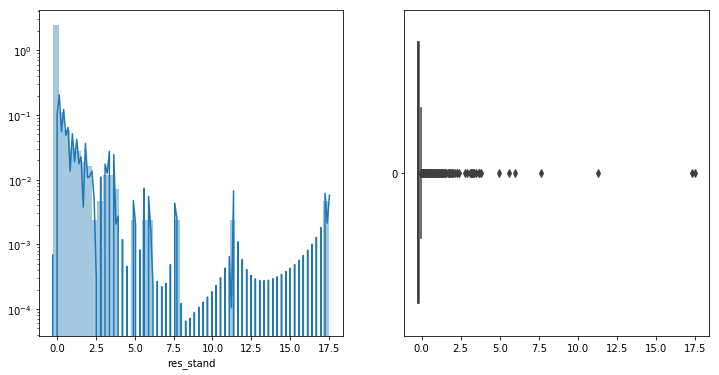

In [542]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,6));


sns.distplot(google_results_df['res_stand'], ax=ax[0]);
ax[0].set(yscale="log")
sns.boxplot(data=google_results_df['res_stand'], orient='h', ax=ax[1]);

In [547]:
# Manually marking some wrong outliers

google_results_df[google_results_df.res_stand > 2].sort_values(by='res_stand', ascending=False)

,link,search,results,res_stand
128,/lionel-messi/profil/spieler/28003,Lionel+Messi+Barcelona,76800000,17.488131
454,/mikel-san-jose/profil/spieler/52469,Mikel+San+José+Athletic+Bilbao,76000000,17.303466
362,/arthur/profil/spieler/362842,Arthur+Barcelona,50100000,11.324953
609,/alisson/profil/spieler/105470,Alisson+Liverpool,34100000,7.631663
183,/sergio-ramos/profil/spieler/25557,Sergio+Ramos+Real+Madrid,26800000,5.946600
52,/neymar/profil/spieler/68290,Neymar+Paris+Saint-Germain,25200000,5.577271
995,/lucas-moura/profil/spieler/77100,Lucas+Moura+Tottenham,22500000,4.954028
456,/eric-miller/profil/spieler/245315,Eric+Miller+Minnesota+United,17500000,3.799875
489,/william/profil/spieler/153207,William+Chaves,16900000,3.661376
544,/clemente/profil/spieler/59372,Clemente+Santa+Clara,16900000,3.661376


In [574]:
to_be_corrected = ['Mikel+San+José+Athletic+Bilbao',
                   'Eric+Miller+Minnesota+United',
                   'William+Chaves',
                   'Clemente+Santa+Clara',
                   'Zé+Manuel+Santa+Clara',
                   'Andrew+Taylor+Bolton',
                   'Diego+Mercado+Independiente',
                   'João+Teixeira+Chaves',
                   'Sam+Johnson+Real+Salt+Lake',
                   'Manuel+Castro+Estudiantes',
                   'Román+Martínez+San+Lorenzo',
                   'João+Lopes+Santa+Clara'
                   'Nicolás+Domingo+Independiente',
                   'Junio+Rio+Ave',
                   'Nicolás+Domingo+Independiente']

for each in to_be_corrected:
    mean_res = round(np.mean(google_results_df.results[google_results_df.res_stand < 20]),0)
    google_results_df.results.loc[google_results_df['search'] == each] = mean_res

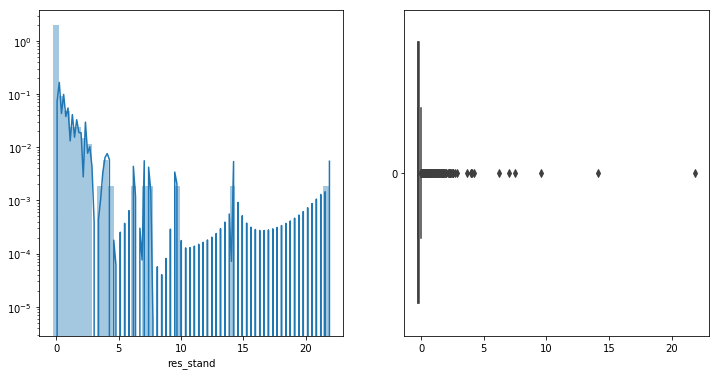

In [861]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,6));


sns.distplot(google_results_df['res_stand'], ax=ax[0]);
ax[0].set(yscale="log")
sns.boxplot(data=google_results_df['res_stand'], orient='h', ax=ax[1]);

In [1623]:
# Manually adjusting some players with zero

google_results_df.sort_values(by='results', ascending=False).head(15)

,link,search,results,res_stand
128,/lionel-messi/profil/spieler/28003,Lionel+Messi+Barcelona,76800000.0,21.843871
362,/arthur/profil/spieler/362842,Arthur+Barcelona,50100000.0,14.165374
609,/alisson/profil/spieler/105470,Alisson+Liverpool,34100000.0,9.564028
183,/sergio-ramos/profil/spieler/25557,Sergio+Ramos+Real+Madrid,26800000.0,7.464663
52,/neymar/profil/spieler/68290,Neymar+Paris+Saint-Germain,25200000.0,7.004529
995,/lucas-moura/profil/spieler/77100,Lucas+Moura+Tottenham,22500000.0,6.228052
785,/vincent-kompany/profil/spieler/9594,Vincent+Kompany+ManCity,15600000.0,4.243721
695,/rafael/profil/spieler/61892,Rafael+Lyon,15100000.0,4.099929
1096,/karim-benzema/profil/spieler/18922,Karim+Benzema+Real+Madrid,14600000.0,3.956137
933,/arturo-vidal/profil/spieler/37666,Arturo+Vidal+Barcelona,14600000.0,3.956137


In [582]:
# Manually adjusting values with zero

# Some specific players with wrong data

to_be_upgraded = {'Alberto+Benito+Real+Zaragoza': 4370000,
                 'Marco+Asensio+Real+Madrid': 7250000}
                  
for key, value in zip(to_be_upgraded.keys(), to_be_upgraded.values()):
    google_results_df.results.loc[google_results_df['search'] == key] = value

In [587]:
# Generalizing for the rest

google_results_df.results.loc[google_results_df['results'] == 0] = np.percentile(google_results_df.results, q=25)

In [588]:
google_results_df['res_stand'] = standardization(google_results_df.results)

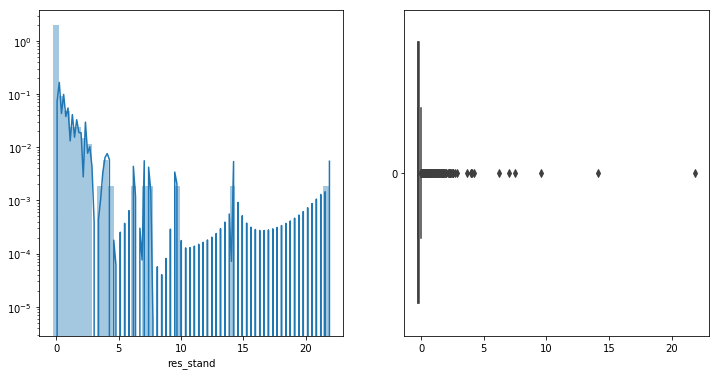

In [1462]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,6));


sns.distplot(google_results_df['res_stand'], ax=ax[0]);
ax[0].set(yscale="log")
sns.boxplot(data=google_results_df['res_stand'], orient='h', ax=ax[1]);
#ax[1].set(xscale='log')

In [592]:
google_results_df.to_csv(r'Final_datasets/Cleaned_data/final_google_results_cleaned.csv',index=False)

### Twitter data

In [4]:
tw_sentiment_df.head()

,Keyword,Link,Positive,Negative,Neutral
0,Trent Alexander-Arnold Liverpool,0 /Players/318871/Show/Trent-Alexander-Ar...,60.000000,4.500000,35.500000
1,Pierre-Emerick Aubameyang Arsenal,0 /Players/44120/Show/Pierre-Emerick-Auba...,33.000000,3.000000,64.000000
2,Neymar Paris Saint-Germain,0 /Players/50835/Show/Neymar\n1 /Pla...,24.000000,10.500000,65.500000
3,Jordan Henderson Liverpool,0 /Players/68659/Show/Jordan-Henderson\n1...,54.500000,8.000000,37.500000
4,Shkodran Mustafi Arsenal,0 /Players/80921/Show/Shkodran-Mustafi\n1...,40.397351,4.635762,54.966887


In [5]:
tw_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
Keyword     408 non-null object
Link        408 non-null object
Positive    408 non-null float64
Negative    408 non-null float64
Neutral     408 non-null float64
dtypes: float64(3), object(2)
memory usage: 16.0+ KB


In [6]:
# Filtering data with suspicious values (100% on one sentiment or 50-50)

tw_ok = tw_sentiment_df.copy()
tw_ok = tw_ok[(tw_ok.Positive % 50 != 0) & (tw_ok.Negative % 50 != 0)]

In [7]:
tw_ok['tw_index'] = tw_ok.Positive*2 - tw_ok.Negative*2 + tw_ok.Neutral

In [8]:
tw_ok.sort_values(by='tw_index',ascending=False).head()

,Keyword,Link,Positive,Negative,Neutral,tw_index
233,Sam Johnson Real Salt Lake,0 /Players/320597/Show/Sam-Johnson\n1 ...,89.189189,2.702703,8.108108,181.081081
320,Semi Ajayi Rotherham,0 /Players/247815/Show/Semi-Ajayi\n1 /...,87.096774,3.225806,9.677419,177.419355
41,Marco Asensio Real Madrid,0 /Players/137467/Show/Marco-Asensio\n1 ...,83.168317,1.980198,14.851485,177.227723
190,Dani Ceballos Real Madrid,0 /Players/144890/Show/Dani-Ceballos\n1 ...,80.952381,1.587302,17.460317,176.190476
387,Toni Kroos Real Madrid,0 /Players/31772/Show/Toni-Kroos\n1 /P...,80.555556,8.333333,11.111111,155.555556


In [9]:
tw_ok.shape

(131, 6)

In [1632]:
tw_ok.to_csv(r'Final_datasets/Cleaned_data/final_twitter_cleaned.csv',index=False)

## Other data

### Several and target

In [4]:
several_and_target_df.head()

,current_value,highest_value,outfitter,last_team,prev_team,prev_prev_team,link
0,£450k,£450k,None,Vitesse,Hull City,Hull U23,/max-clark/profil/spieler/183291
1,£2.70m,£2.70m,None,Levante,Spezia Calcio,CD Leganés,/sergio-postigo/profil/spieler/158791
2,£540k,£630k,None,MSV Duisburg,VfL Osnabrück,Westf. Rhynern,/stanislav-iljutcenko/profil/spieler/191292
3,£6.75m,£6.75m,None,Boca Juniors,CD Cruz Azul,Lanús,/ivan-marcone/profil/spieler/90451
4,£6.30m,£6.30m,None,Montpellier,FC Metz,US Créteil,/florent-mollet/profil/spieler/222859


#### Dropping outfitter since the scraping task did not obtain anything

In [5]:
several_and_target_df.drop(labels='outfitter', axis=1, inplace=True)

#### Correcting value columns

In [6]:
to_be_replaced = ["£",'k','m','.','-']
to_be_instead = ["", "000", "0000", "", "0"]

for replace, instead in zip(to_be_replaced, to_be_instead):
    several_and_target_df['current_value'] = [x.replace(replace,instead) for x in several_and_target_df.current_value]
    several_and_target_df['highest_value'] = [x.replace(replace,instead) for x in several_and_target_df.highest_value]

In [7]:
several_and_target_df['current_value'] = several_and_target_df.current_value.astype(int)
several_and_target_df['highest_value'] = several_and_target_df.highest_value.astype(int)

In [8]:
several_and_target_df.sort_values(by='current_value', ascending=False).head(10)

,current_value,highest_value,last_team,prev_team,prev_prev_team,link
229,180000000,180000000,Paris SG,Monaco,Paris SG,/kylian-mbappe/profil/spieler/342229
52,162000000,162000000,Paris SG,FC Barcelona,Santos FC,/neymar/profil/spieler/68290
128,144000000,162000000,FC Barcelona,FC Barcelona B,Barcelona C,/lionel-messi/profil/spieler/28003
1143,108000000,108000000,Man City,Liverpool,Liverpool U18,/raheem-sterling/profil/spieler/134425
390,76500000,76500000,Liverpool,Southampton,RB Salzburg,/sadio-mane/profil/spieler/200512
1119,72000000,72000000,Real Madrid,Bayern Munich,Bay. Leverkusen,/toni-kroos/profil/spieler/31909
156,72000000,81000000,Real Madrid,Espanyol,Real Madrid,/marco-asensio/profil/spieler/296622
320,72000000,72000000,FC Barcelona,Bor. M'gladbach,M'gladbach U19,/marc-andre-ter-stegen/profil/spieler/74857
53,67500000,67500000,Arsenal,Bor. Dortmund,Saint-Étienne,/pierre-emerick-aubameyang/profil/spieler/58864
372,58500000,58500000,RB Leipzig,VfB Stuttgart,Stuttgart U19,/timo-werner/profil/spieler/170527


In [9]:
several_and_target_df.current_value[several_and_target_df['current_value'] == 0] = np.percentile(several_and_target_df.current_value, 25)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
several_and_target_df.highest_value[several_and_target_df['highest_value'] == 0] = np.percentile(several_and_target_df.highest_value, 25)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
several_and_target_df.current_value = several_and_target_df.current_value.astype(int)
several_and_target_df.highest_value = several_and_target_df.highest_value.astype(int)

#### Final checks on value and target variable

Since the target variable has an extreme skewed distribution to the right, due to the presence of outliers, in the following lines I will be applying some log transformation on the target variable to reduce the noise.

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


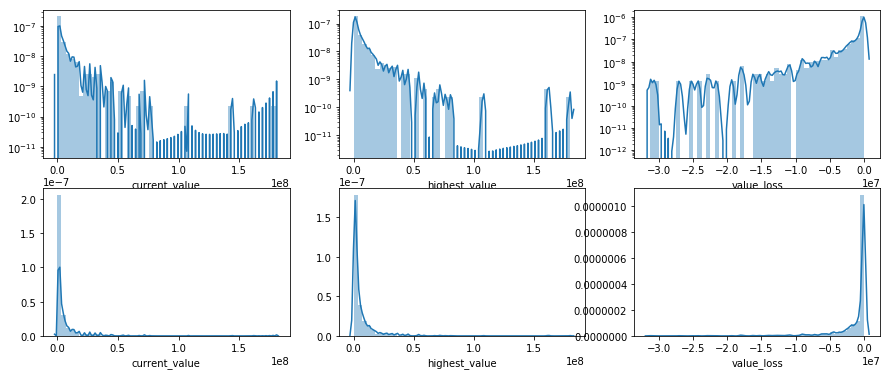

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,6));

sns.distplot(several_and_target_df.current_value, ax=ax[0,0]);
ax[0,0].set(yscale="log")
sns.distplot(several_and_target_df.highest_value, ax=ax[0,1]);
ax[0,1].set(yscale="log")
sns.distplot(several_and_target_df.value_loss, ax=ax[0,2]);
ax[0,2].set(yscale="log")

sns.distplot(several_and_target_df.current_value, ax=ax[1,0]);
sns.distplot(several_and_target_df.highest_value, ax=ax[1,1]);
sns.distplot(several_and_target_df.value_loss, ax=ax[1,2]);

In [118]:
# Testing some transformations on the target variable since it's extremly skewed

from scipy.stats import boxcox
log_target = boxcox(several_and_target_df.current_value, 0)
double_trans = boxcox(log_target, 0)

In [119]:
several_and_target_df['current_log'] = log_target
several_and_target_df['double_trans'] = double_trans

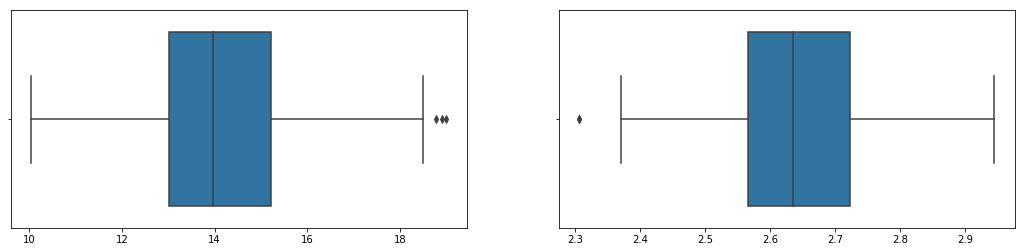

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
sns.boxplot(log_target, ax=ax[0])
sns.boxplot(double_trans, ax=ax[1])
#ax.set_xscale('symlog')

In [121]:
several_and_target_df.to_csv(r'Final_datasets/Cleaned_data/Market_value.csv',index=False)

### Basic info (without age)

In [708]:
basic_info_df.head()

,name,position,height,weight,team
0,Max Clark,Defender (Left),180.0,73.0,Vitesse
1,Sergio Postigo,Defender (Centre),184.0,78.0,Levante
2,Stanislav Iljutcenko,Forward,189.0,82.0,Duisburg
3,Iván Marcone,Defensive Midfielder (C),184.0,79.0,Boca Juniors
4,Florent Mollet,"Attacking Midfielder (Centre, Left)",174.0,67.0,Montpellier


In [709]:
basic_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
name        1198 non-null object
position    1198 non-null object
height      1169 non-null float64
weight      1156 non-null float64
team        1200 non-null object
dtypes: float64(2), object(3)
memory usage: 47.0+ KB


In [716]:
# Replacing null values

basic_info_df.height.replace(to_replace=np.nan, value=0, inplace=True)
basic_info_df.weight.replace(to_replace=np.nan, value=0, inplace=True)

In [717]:
# Converting types

basic_info_df.height = basic_info_df.height.astype(int)
basic_info_df.weight = basic_info_df.weight.astype(int)

In [722]:
# Changing zeros per averages

basic_info_df.height[basic_info_df.height == 0] = basic_info_df.height.mean()
basic_info_df.weight[basic_info_df.weight == 0] = basic_info_df.weight.mean()

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [725]:
# Checking position column

basic_info_df.position.value_counts()

Defender (Centre)                             147
Forward                                       120
Goalkeeper                                     94
Defensive Midfielder (C)                       90
Defender (Left)                                87
Midfielder (Centre)                            86
Defender (Right)                               73
Midfielder                                     60
Attacking Midfielder (Centre, Left, Right)     53
Attacking Midfielder (Left, Right)             52
Defender                                       36
Defender (Centre, Right)                       35
Attacking Midfielder (Left)                    32
Midfielder (Centre, Left, Right)               32
Defender (Centre, Left)                        31
Attacking Midfielder (Centre)                  28
Attacking Midfielder (Centre, Left)            24
Attacking Midfielder (Right)                   24
Defender (Left, Right)                         22
Defender (Centre, Left, Right)                 17


In [727]:
# As we can see in the list above, there are a lot of positions defined.
# So we're gonna clean that list in order to reduce the list by grouping simmilar positions.
# We're also gonna keep each player preffered position (the first one if having more than one)
# And we'll create a new feature with the number of position each player specified

positions_list = ['Goalkeeper', 'Defender', 'Defensive Midfielder', 'Midfielder', 'Atacking Midfielder', 'Forward']
pref_side_lst = ['Centre', 'Left', 'Right']

In [797]:
# Obtaining new features out of the data

pos_def = []
pref_side = []
sides = []
for each_p_pos in basic_info_df.position:
    pref_side_flag = False
    pos_def_flag = False
    sides_count = 0
    
    # Creating definitive position feature
    for each_d_pos in positions_list:
        if str(each_d_pos) in str(each_p_pos) and pos_def_flag == False:
            pos_def.append(each_d_pos)
            pos_def_flag = True
    if not pos_def_flag:
        pos_def.append(np.nan)
    
    # Creating preffered side feature
    for each_pref in pref_side_lst:
        if str(each_pref) in str(each_p_pos):
            sides_count = sides_count + 1
            
            if pref_side_flag == False:
                pref_side.append(each_pref)
                pref_side_flag = True
    if not pref_side_flag:
        pref_side.append('None')
    
    # Creating number of sides feature
    sides.append(sides_count)

In [802]:
basic_info_df['pos_def'] = pos_def
basic_info_df['pref_side'] = pref_side
basic_info_df['sides'] = [x if x != 0 else 1 for x in sides]

In [803]:
basic_info_df.pos_def.value_counts()

Defender                448
Midfielder              446
Forward                 120
Goalkeeper               94
Defensive Midfielder     90
Name: pos_def, dtype: int64

In [804]:
basic_info_df.pref_side.value_counts()

Centre    486
None      402
Left      210
Right     102
Name: pref_side, dtype: int64

In [805]:
basic_info_df.sides.value_counts()

1    889
2    209
3    102
Name: sides, dtype: int64

In [808]:
basic_info_df.head()

,name,position,height,weight,team,pos_def,pref_side,sides
0,Max Clark,Defender (Left),180.0,73.0,Vitesse,Defender,Left,1
1,Sergio Postigo,Defender (Centre),184.0,78.0,Levante,Defender,Centre,1
2,Stanislav Iljutcenko,Forward,189.0,82.0,Duisburg,Forward,None,1
3,Iván Marcone,Defensive Midfielder (C),184.0,79.0,Boca Juniors,Defensive Midfielder,None,1
4,Florent Mollet,"Attacking Midfielder (Centre, Left)",174.0,67.0,Montpellier,Midfielder,Centre,2


In [1625]:
basic_info_df.to_csv(r'Final_datasets/Cleaned_data/Basic_info.csv',index=False)

### Injuries and ages

In [1382]:
injuries_df.sort_values(by='games_missed', ascending=True).head()

,player,days_missed,games_missed
0,/max-clark/profil/spieler/183291,0,0
593,/alejo-montero/profil/spieler/649998,0,0
592,/rodrigo-salinas/profil/spieler/125750,0,0
1155,/joaquin-varela/profil/spieler/553421,0,0
587,/brent-kallman/profil/spieler/226643,0,0


In [1383]:
injuries_df.days_missed = [int(x) for x in injuries_df.days_missed]
injuries_df.games_missed = [int(x) for x in injuries_df.games_missed]

In [1386]:
injuries_df.columns = ['link', 'days_missed', 'games_missed']

In [1387]:
# Merging with age

injuries_and_age = injuries_df.merge(ages_df, how='inner', on='link')

In [1391]:
injuries_and_age.drop_duplicates(subset='link',inplace=True)

In [1398]:
# Doing some binning over the age of each player

injuries_and_age['age_group'] = ['Sub_20' if x < 21 else '21-23' if x < 24 else '24-26' \
                                 if x < 27 else '27-30' if x < 31 else '31-34' if x < 35 \
                                 else 'Plus_35' for x in injuries_and_age.age]

In [1401]:
injuries_and_age.age_group.value_counts()

27-30      310
24-26      297
21-23      255
31-34      187
Sub_20     103
Plus_35     47
Name: age_group, dtype: int64

In [1400]:
avg_miss = injuries_and_age[injuries_and_age.days_missed > 0].groupby('age_group').mean()

In [1418]:
# In the next lines we're gonna extract the number of days and games missed by each player

days = []
games = []
for each in range(len(injuries_and_age)):
    if injuries_and_age.iloc[each,1] == 0:
        days.append(round(avg_miss.loc[injuries_and_age.iloc[each,4],'days_missed'],0))
        games.append(round(avg_miss.loc[injuries_and_age.iloc[each,4],'games_missed'],0))
    elif injuries_and_age.iloc[each,1] > 0:
        days.append(injuries_and_age.iloc[each,1])
        games.append(injuries_and_age.iloc[each,2])

In [1420]:
injuries_and_age['days_miss'] = days
injuries_and_age['games_miss'] = games

In [1425]:
injuries_and_age.drop('days_missed',axis=1,inplace=True)
injuries_and_age.drop('games_missed',axis=1,inplace=True)

In [1428]:
# Creating feature according to the number of days missed because of being injured or suspended
# Taking the assumption that each player starts its professional career at the age of 16

injuries_and_age['miss_days_per_y'] = injuries_and_age.days_miss / (injuries_and_age.age-16)

In [1431]:
injuries_and_age.sort_values(by='miss_days_per_y',ascending=False).head()

,link,age,age_group,days_miss,games_miss,miss_days_per_y
1164,/ryo-miyaichi/profil/spieler/129688,26,24-26,1207.0,121.0,120.700000
493,/joe-gomez/profil/spieler/256178,21,21-23,565.0,97.0,113.000000
876,/felix-platte/profil/spieler/195782,23,21-23,773.0,88.0,110.428571
920,/federico-mattiello/profil/spieler/200194,23,21-23,702.0,58.0,100.285714
115,/dominik-baumgartner/profil/spieler/206906,22,21-23,589.0,82.0,98.166667


In [1433]:
final_injuries = injuries_and_age.drop('age', axis=1)

In [1634]:
final_injuries.to_csv(r'Final_datasets/Cleaned_data/Injuries_and_age.csv',index=False)

### Awards

In [1559]:
awards_categories_df.tail()

,Awards,Category
255,World Cup third place,World Cup third place
256,World Cup winner,World Cup winner
257,World's Best Goalkeeper,Top individuals
258,Wurttemberg Cup winner,Others
259,Young player of the year,Minor individuals


In [1570]:
awards_df.fillna(value=0,inplace=True)

In [1571]:
for category in awards_categories_df.Category.unique():
    sliced = awards_categories_df.Awards[awards_categories_df.Category==category].values
    awards_df[category] = awards_df[sliced].sum(numeric_only=True,axis=1)

In [1589]:
cols_to_save = list(awards_categories_df.Category.unique())
cols_to_save.append('Unnamed: 0')

In [1591]:
awards_def = awards_df[cols_to_save]

In [1592]:
awards_def.shape

(1200, 26)

In [1606]:
# Dropping small awards

awards_def.drop(['Player ','Others ', 'Promotion '],axis=1,inplace=True)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [1608]:
awards_def.columns = ['Continental Club Winner', 'Continental Nat Winner',
       'Minor individuals ', 'League T2 Club Winner', 'Top individuals ',
       'League T1 Club Winner', 'Continental Club Runner-up',
       'Continental Nat Runner-up', 'Major individuals ',
       'League T1 Runner-up', 'Under Continental Runner-up',
       'Under Continental Winner', 'FIFA Club World Cup participant ',
       'FIFA Club World Cup winner ', 'Olympic medalist ',
       'League T2 Runner-up', 'Second place at the Olympic Games ',
       'Third place at the Olympic Games ', 'World Cup participant ',
       'World Cup runner-up ', 'World Cup third place ', 'World Cup winner ','link']

In [1614]:
awards_def = awards_def[['link','Continental Club Winner', 'Continental Nat Winner',
       'Minor individuals ', 'League T2 Club Winner', 'Top individuals ',
       'League T1 Club Winner', 'Continental Club Runner-up',
       'Continental Nat Runner-up', 'Major individuals ',
       'League T1 Runner-up', 'Under Continental Runner-up',
       'Under Continental Winner', 'FIFA Club World Cup participant ',
       'FIFA Club World Cup winner ', 'Olympic medalist ',
       'League T2 Runner-up', 'Second place at the Olympic Games ',
       'Third place at the Olympic Games ', 'World Cup participant ',
       'World Cup runner-up ', 'World Cup third place ', 'World Cup winner ']]

In [1616]:
awards_def['total_awards'] = awards_def.sum(numeric_only=True,axis=1)

/Users/gonzaloferreiro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1618]:
awards_def.head()

,link,Continental Club Winner,Continental Nat Winner,Minor individuals,League T2 Club Winner,Top individuals,League T1 Club Winner,Continental Club Runner-up,Continental Nat Runner-up,Major individuals,...,FIFA Club World Cup winner,Olympic medalist,League T2 Runner-up,Second place at the Olympic Games,Third place at the Olympic Games,World Cup participant,World Cup runner-up,World Cup third place,World Cup winner,total_awards
0,/max-clark/profil/spieler/183291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/sergio-postigo/profil/spieler/158791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/stanislav-iljutcenko/profil/spieler/191292,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,/ivan-marcone/profil/spieler/90451,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,/florent-mollet/profil/spieler/222859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1629]:
awards_def.to_csv(r'Final_datasets/Cleaned_data/Awards_def.csv',index=False)

### National appeareces, ranking and agent

#### National appearences with nat team ranking

In [1183]:
national_apps_df.head()

,link,nationality,minutes,agent
0,/max-clark/profil/spieler/183291,England,0,KIN
1,/sergio-postigo/profil/spieler/158791,Spain,0,JPA Soccer
2,/stanislav-iljutcenko/profil/spieler/191292,Russia,0,Coaches & More GmbH
3,/ivan-marcone/profil/spieler/90451,Argentina,0,Christian Bragarnik
4,/florent-mollet/profil/spieler/222859,France,0,No agent


In [1185]:
national_apps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
link           1200 non-null object
nationality    1198 non-null object
minutes        1200 non-null int64
agent          1200 non-null object
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


In [1224]:
nat_teams_ranking_df.tail()

,nationality,pos
170,Malaysia,171
171,Papua N. Guinea,172
172,Saint Lucia,173
173,Moldova,174
174,Grenada,175


In [1187]:
nat_teams_ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
Country     175 non-null object
Position    175 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [1292]:
# Matching columns name

nat_teams_ranking_df.columns = ["nationality",'nation_pos']

In [1293]:
# Adjusting some countries name by hand

nat_teams_ranking_df['nationality'] = ['Bosnia-Herzegovina' if x == 'Bosnia' else 'United States' if \
                                       x == "USA" else "Korea, South" if x == "South Korea" else "Cote d'Ivoire" \
                                       if x == "Ivory Coast" else "Northern Ireland" if x == 'N. Ireland' \
                                       else x for x in nat_teams_ranking_df.nationality]

In [1294]:
app_with_rank = national_apps_df.merge(nat_teams_ranking_df, how='left', on='nationality')

In [1297]:
app_with_rank.nationality[pd.isnull(app_with_rank.nation_pos)].value_counts()

Guadeloupe                 2
Chinese Taipei (Taiwan)    1
Curacao                    1
Hongkong                   1
Equatorial Guinea          1
Cuba                       1
Chad                       1
Name: nationality, dtype: int64

In [1299]:
app_with_rank.fillna(app_with_rank.nation_pos.max(), inplace=True)

In [1300]:
app_with_rank.head()

,link,nationality,minutes,agent,nation_pos
0,/max-clark/profil/spieler/183291,England,0,KIN,4.0
1,/sergio-postigo/profil/spieler/158791,Spain,0,JPA Soccer,9.0
2,/stanislav-iljutcenko/profil/spieler/191292,Russia,0,Coaches & More GmbH,46.0
3,/ivan-marcone/profil/spieler/90451,Argentina,0,Christian Bragarnik,11.0
4,/florent-mollet/profil/spieler/222859,France,0,No agent,2.0


#### Agent cleaning

In [1301]:
app_with_rank.agent.value_counts().head()

No agent                233
Relatives                38
no agent                 26
not clarified            24
Stellar Football Ltd     20
Name: agent, dtype: int64

In [1302]:
# Classifying agents according to the number of occurrences, not having agent or being relatives

agent_clas = {}

for agent, players in zip(app_with_rank.agent.value_counts().index, app_with_rank.agent.value_counts()):
    if agent == 'No agent' or agent == 'no agent' or agent == 'not clarified':
        agent_clas[agent] = 'No agent'
    elif agent == 'Relatives':
        agent_clas[agent] = 'Relatives'
    elif players < 3:
        agent_clas[agent] = 'Small'
    elif players < 10:
        agent_clas[agent] = "Medium"
    else:
        agent_clas[agent] = 'Big'

In [1303]:
app_with_rank['type_agent'] = [agent_clas[x] for x in app_with_rank.agent]

In [1304]:
app_with_rank.drop('agent',axis=1,inplace=True)

#### Pond minutes by ranking

In [1310]:
# It's not the same having played 100 minutes for the english national team, that having played 100 minutes
# for the peruvian national team. That's why we'll pondering the minutes played according to the current
# position of each national team in FIFA's ranking.
# We'll be doing that by multiplying the minutes played by 1/ranking

app_with_rank['pond_min'] = app_with_rank.minutes * (1/app_with_rank.nation_pos)

In [1314]:
app_with_rank.drop('nation_pos', axis=1, inplace=True)

In [1318]:
app_with_rank.sort_values(by='pond_min', ascending=False).head(10)

,link,nationality,minutes,type_agent,pond_min
455,/jan-vertonghen/profil/spieler/43250,Belgium,9562,Medium,9562.000000
785,/vincent-kompany/profil/spieler/9594,Belgium,7068,Small,7068.000000
797,/kevin-mirallas/profil/spieler/33639,Belgium,2815,Small,2815.000000
52,/neymar/profil/spieler/68290,Brazil,8022,Relatives,2674.000000
1096,/karim-benzema/profil/spieler/18922,France,5129,Small,2564.500000
757,/thiago-silva/profil/spieler/29241,Brazil,6391,Small,2130.333333
113,/iker-casillas/profil/spieler/3979,Spain,13444,Small,1493.777778
359,/laurent-ciman/profil/spieler/22338,Belgium,1493,No agent,1493.000000
183,/sergio-ramos/profil/spieler/25557,Spain,12686,Relatives,1409.555556
475,/steve-mandanda/profil/spieler/23951,France,2462,Small,1231.000000


In [1630]:
app_with_rank.to_csv(r'Final_datasets/Cleaned_data/Appearences_with_ranking.csv',index=False)